In [1]:
import torch
from numpy import loadtxt
from matplotlib import pyplot as plt

In this tutorial, we will demonstrate how to use the `NFdeconvolve` library to recover the underlying signal distribution from noisy measurements. Specifically, we will:

- Load a dataset.
- Define the noise distribution as a PyTorch distribution.
- Build and train the deconvolution model.
- Compare the recovered distribution to the ground truth (for our example a Gamma distribution)

In [2]:
import NFdeconvolve

## Load data
For this example, we will use a dataset pre-generated for the demonstrations in the main article.  To make sure this dataset file is located at `paper_examples/datasets/`, read the main `GitHub` readme file. The user should replace this with their own dataset.

In [3]:
mu_a,sig_a = 10,1
shape,scale = 9,1

filename = f'N_{mu_a}_{sig_a}_G_{shape}_{scale}.csv'
data = torch.tensor(loadtxt('paper_examples/datasets/'+filename)[:10000]).float()

 For the current implementation, the dataset must be a single-valued array of numerical data (1D array). Ensure your dataset is loaded as such. If you're using a custom dataset, you can load it with `NumPy`, `Pandas`, or directly in `PyTorch`.

In [4]:
data

tensor([18.0122, 32.4405, 27.1943,  ..., 22.5785, 16.1118, 16.8502])

## Specify noise distributions
The noise distribution must be defined as an object of the PyTorch distribution. In this example, the data was generated using a Gaussian noise model, thus it is the one we are defining.

In [5]:
a_distribution= torch.distributions.Normal(torch.tensor(1.*mu_a),torch.tensor(1.*sig_a))

If your noise follows a different distribution (e.g., Poisson, Uniform), use the corresponding [PyTorch distribution class](https://pytorch.org/docs/stable/distributions.html).

## Build the deconvolution model

We now build a normalizing flow (NF) deconvolution model using the `NFdeconvolve.Deconvolver` class.

In [6]:
model=NFdeconvolve.Deconvolver(data,a_distribution)

/home/pessoa/Codes/Zeta/NFdeconvolve.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("shift", torch.tensor(shift))
/home/pessoa/Codes/Zeta/NFdeconvolve.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("scale", torch.tensor(scale))


## Train the model

Train the model using the `.train()` method. By default, the model will optimize for a predefined number of epochs. However, training can stop early if the neural network's gradients become sufficiently small, indicating that the optimization has likely converged.

In this example, early stopping is expected due to the simplicity of the dataset.

In [7]:
model.train()

  6%|▌         | 299/5000 [00:37<09:44,  8.04it/s]

Stopping early at iteration 300 due to small gradient norm: 0.037923865020275116


## Retrieve the distribution

After training, we can retrieve the estimated probability distribution of the signal.

In [8]:
x, px = model.get_pdf()

which we can plot as

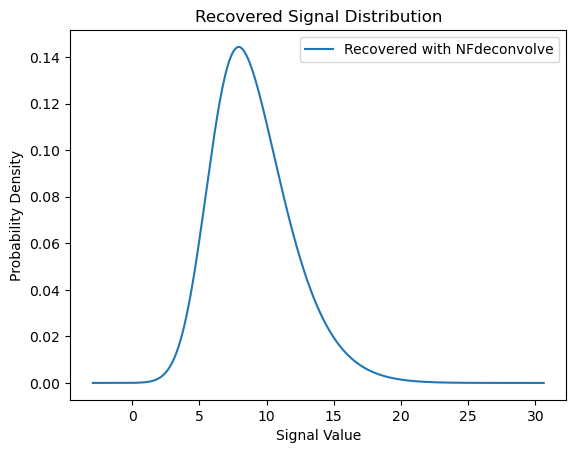

In [9]:
plt.plot(x.cpu(), px.cpu(), label='Recovered with NFdeconvolve')
plt.xlabel('Signal Value')
plt.ylabel('Probability Density')
plt.legend()
plt.title('Recovered Signal Distribution')
plt.show()

## Comparison with ground truth

If you have ground truth information, you can compare it against the recovered distribution. In this example, we compare with the Gamma distribution used to generate this dataset.

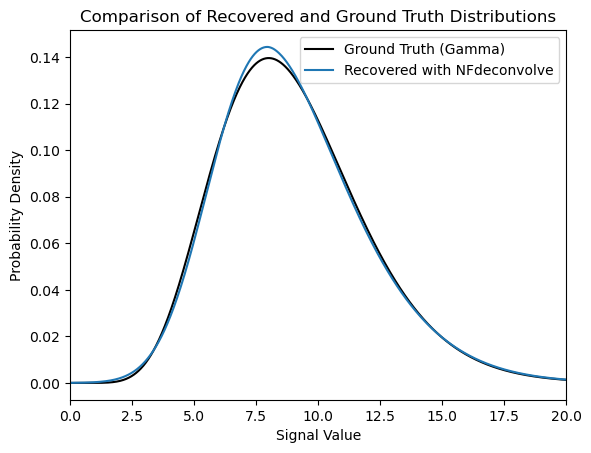

In [10]:
from paper_examples.basis import logprob_gamma

# Ground truth Gamma PDF
true_pdf = torch.exp(logprob_gamma(x.cpu(), torch.tensor(shape), torch.tensor(scale)))

plt.plot(x.cpu(), true_pdf.cpu(), label='Ground Truth (Gamma)',color='k')
plt.plot(x.cpu(), px.cpu(), label='Recovered with NFdeconvolve')
plt.xlabel('Signal Value')
plt.ylabel('Probability Density')
plt.legend()
plt.title('Comparison of Recovered and Ground Truth Distributions')
plt.xlim(0,20)
plt.show()

## Example with product

Now, for comparison, let us show a similar process for data generate as the product. In short, we can repeat the training process using the `NFdeconvolve.ProdDeconvolver` class.

In [11]:
filename = f'prod_N_{mu_a}_{sig_a}_G_{shape}_{scale}.csv'
data = torch.tensor(loadtxt('paper_examples/datasets/'+filename)[:10000]).float()

In [12]:
model_prod=NFdeconvolve.ProdDeconvolver(data,a_distribution)
model_prod.train()
x, px = model_prod.get_pdf()

/home/pessoa/Codes/Zeta/NFdeconvolve.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("shift", torch.tensor(shift))
/home/pessoa/Codes/Zeta/NFdeconvolve.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("scale", torch.tensor(scale))
  0%|          | 0/1000 [00:00<?, ?it/s]

 30%|██▉       | 299/1000 [00:39<01:33,  7.48it/s]

Stopping early at iteration 300 due to small gradient norm: 0.013437538407742977


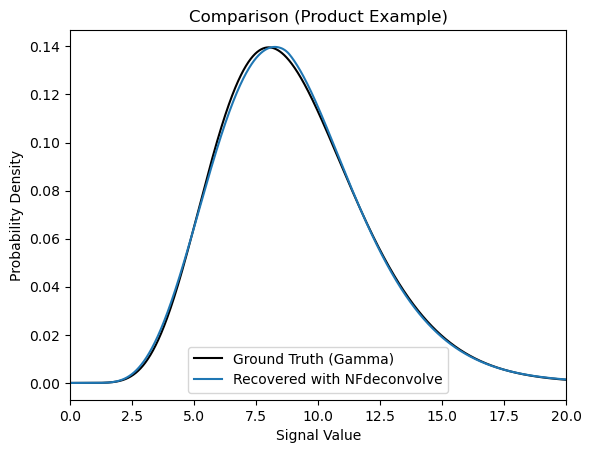

In [13]:
true_pdf = torch.exp(logprob_gamma(x.cpu(), torch.tensor(shape), torch.tensor(scale)))

plt.plot(x.cpu(), true_pdf.cpu(), label='Ground Truth (Gamma)',color='k')
plt.plot(x.cpu(), px.cpu(), label='Recovered with NFdeconvolve')
plt.xlabel('Signal Value')
plt.ylabel('Probability Density')
plt.legend()
plt.title('Comparison (Product Example)')
plt.xlim(0,20)
plt.show()